# ELEN0016 Computer Vision Project: Detecting droplets and counting cells using OpenCV

This project is part of the ELEN0016 course at the Université de Liège. The goal of this project is to detect droplets and count cells in a given sequence. The project uses the OpenCV library to perform the image processing such as backgroung subtraction, thresholding, etc. The project is written in Python and can be run be simply lauching the Jupyter Notebook `main.ipynb` by correctly setting the different path variables to locate the data folders.

## Authors
- [Romain Lambermont](https://github.com/lambi702)  (s190931, romain.lambermont@student.uliege.be)
- [Arthur Louis](https://github.com/Opeka-2201)     (s191230, alouis@student.uliege.be)
- [Tom Navez](https://github.com/TomNavez)          (s192507, tom.navez@student.uliege.be)

## Installation
To install the project, simply clone the repository and install the required packages using the following command:
```bash
git clone https://github.com/lambi702/CV-Video_annotation.git
pip install -r requirements.txt
```

## Usage
To run the project, simply launch the Jupyter Notebook `main.ipynb` and set the different path variables to locate the data folders. The notebook will then run the different steps of the project and compute the results into a `.json` file and a `.tif` sequence.

## Imports

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json

## Creation of different folders and specification of the paths

In [2]:
DATA_PATH = 'data/'
SEQUENCES_PATH = DATA_PATH + 'sequences/'
DROPLETS_PATH = DATA_PATH + 'droplets/'
GENERATED_PATH = DATA_PATH + 'generated/'
INTEREST_FILE = '9-3.tif'

if not os.path.exists(SEQUENCES_PATH + INTEREST_FILE):
    raise("No sequence found matching the interest file: ", SEQUENCES_PATH + INTEREST_FILE)

if not os.path.exists(DROPLETS_PATH):
    os.makedirs(DROPLETS_PATH)
else:
    for file in os.listdir(DROPLETS_PATH):
        os.remove(os.path.join(DROPLETS_PATH, file))
    os.rmdir(DROPLETS_PATH)
    os.makedirs(DROPLETS_PATH)

if not os.path.exists(GENERATED_PATH):
    os.makedirs(GENERATED_PATH)
else:
    for file in os.listdir(GENERATED_PATH):
        os.remove(os.path.join(GENERATED_PATH, file))
    os.rmdir(GENERATED_PATH)
    os.makedirs(GENERATED_PATH)

## Image loading

In [3]:
def equalize_sequence(sequence):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    return [clahe.apply(frame) for frame in sequence]

def load_sequence(file, equalized=False):
    sequence = cv2.imreadmulti(file, flags=cv2.IMREAD_GRAYSCALE)[1]

    if equalized:
        sequence = equalize_sequence(sequence)

    return sequence

def load_image(file):
    return cv2.imread(file, flags=cv2.IMREAD_GRAYSCALE)

Loading sequence from file: data/sequences/9-3.tif
Loaded 100 images
First image: 


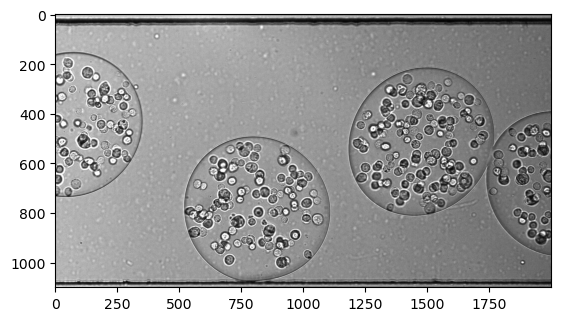

In [4]:
file = SEQUENCES_PATH + INTEREST_FILE
print('Loading sequence from file: {}'.format(file))

images = np.array(load_sequence(file))
nb_images = images.shape[0]

print('Loaded {} images'.format(nb_images))
print('First image: ')
plt.imshow(images[0], cmap='gray')
plt.show()

## Background subtraction and mask creation

In [5]:
def background_substraction(images):
    bg = np.median(images, axis=0)
    mask = np.abs(images - bg) > 35
    mask = mask / np.max(mask)
    return mask.astype(np.uint8) * 255

def get_masks(images):
    masks = background_substraction(images)
    return masks

masks = get_masks(images)

First mask: 


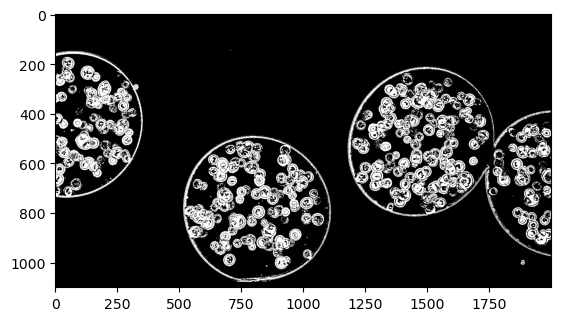

In [6]:
print('First mask: ')
plt.imshow(masks[0], cmap='gray')
plt.show()

## Bounding box creation

In [7]:
def get_contours(mask):
    def get_boundaries(mask):
        boundaries = np.zeros(mask.shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 350:
                cv2.drawContours(boundaries, [contour], 0, 255, 5)

        return np.array(boundaries, dtype=np.uint8)
    
    def get_circles(mask):
        return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=1, minDist=500, param1=35, param2=15, minRadius=270, maxRadius=350)
    
    def get_bb(mask):
        circles = get_circles(mask)
        bb = []
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0,:]:
                x, y, r = circle
                x = int(x)
                y = int(y)
                r = int(r)
                if x-r < 0 or y-r < 0 or x+r > mask.shape[1] or y+r > mask.shape[0]:
                    continue
                bb.append((x-r, y-r, 2*r, 2*r))
        return bb
    
    mask = get_boundaries(mask)
    bb = get_bb(mask)
    return mask, bb

def draw_bbs(masks):
    ims_bb = []
    bbs = []

    print('Drawing bounding boxes...')

    for mask in tqdm(masks):
        im_bb = mask.copy()
        bb = get_contours(mask)[1]
        bbs.append(bb)

        for b in bb:
            cv2.rectangle(im_bb, (b[0], b[1]), (b[0]+b[2], b[1]+b[3]), 255, 5)
        ims_bb.append(im_bb)

    return ims_bb, bbs

masks_with_bbs, bounding_boxes = draw_bbs(masks)

Drawing bounding boxes...


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


First bounding boxes: 
[(1219, 209, 554, 554), (512, 486, 576, 576)]
First contour: 


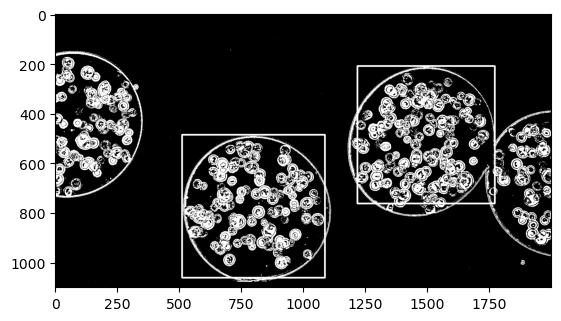

In [8]:
print('First bounding boxes: ')
print(bounding_boxes[0])

print('First contour: ')
plt.imshow(masks_with_bbs[0], cmap='gray')
plt.show()

## Counting the cells inside the droplets

In [9]:
for frame in tqdm(range(len(bounding_boxes))):
    for bb_id, _ in enumerate(bounding_boxes[frame]):
        x, y, w, h = bounding_boxes[frame][bb_id]
        droplet = masks[frame][y:y+h, x:x+w]
        cv2.imwrite(DROPLETS_PATH + 'droplet_{}_{}.tif'.format(str(frame+1).zfill(2), bb_id), droplet)
        
        with open(DROPLETS_PATH + 'droplet_{}_{}.json'.format(str(frame+1).zfill(2), bb_id), 'w') as f:
            json.dump({'x': x, 'y': y, 'w': w, 'h': h}, f)

print('Number of dectected droplets: {}'.format(int(len(os.listdir(DROPLETS_PATH))/2)))

100%|██████████| 100/100 [00:01<00:00, 71.64it/s]

Number of dectected droplets: 216


In [10]:
def count_cells(file_tif, file_json):
    WhiteThreshold = 0.40
    image = load_image(file_tif)
    with open(file_json, 'r') as f:
        data = json.load(f)

    l_circle = []
    #circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=400, param2=20, minRadius=10, maxRadius=30)
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT_ALT, dp=0.5, minDist=22, param1=300, param2=0.01, minRadius=10, maxRadius=30)

    for circle in circles[0]:
        x, y , r = circle
        x = int(x)
        y = int(y)
        r = int(r)
        if np.sum(image[y-r:y+r, x-r:x+r])/(2*r)**2 < 255*WhiteThreshold:
            continue
        l_circle.append([int(x + data['x']), int(y + data['y']), r])

    return l_circle

In [11]:
name = INTEREST_FILE.split('.')[0]
filenames_droplets = os.listdir(DROPLETS_PATH)
files_tif = [f for f in filenames_droplets if f.endswith('.tif')]

for frame in tqdm(range(1, nb_images+1)):
    files = [f for f in files_tif if f.startswith('droplet_{}'.format(str(frame).zfill(2)))]

    for file in files:
        file_json = file.replace('.tif', '.json')
        cells = count_cells(DROPLETS_PATH + file, DROPLETS_PATH + file_json)

        with open(DROPLETS_PATH + file_json, 'r') as f:
            box = json.load(f)
            box = [box['x'], box['y'], box['w'], box['h']]

        with open(GENERATED_PATH + file_json, 'w') as f:
            json.dump({name + '_frame_' + str(frame): {'box': box, 'cells': cells}}, f)

100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


In [12]:
""" # comparison with ground truth
name = INTEREST_FILE.split('.')[0]
filenames_droplets = os.listdir(DROPLETS_PATH)
files_tif = [f for f in filenames_droplets if f.endswith('.tif')]
json_renaud = json.load(open(SEQUENCES_PATH + 'val.json', 'r'))
cell_count = []
cell_count_truth = []

for key in json_renaud.keys():
    cell_count_truth.append((json_renaud[key][1]))

for frame in tqdm(range(1, nb_images+1)):
    files = [f for f in files_tif if f.startswith('droplet_{}'.format(str(frame).zfill(2)))]

    for file in files:
        file_json = file.replace('.tif', '.json')
        cells = count_cells(DROPLETS_PATH + file, DROPLETS_PATH + file_json)

        cell_count.append(len(cells))

        with open(DROPLETS_PATH + file_json, 'r') as f:
            box = json.load(f)
            box = [box['x'], box['y'], box['w'], box['h']]

        with open(GENERATED_PATH + file_json, 'w') as f:
            json.dump({name + '_frame_' + str(frame): {'box': box, 'cells': cells}}, f)

print(np.mean(cell_count))
print(np.mean(cell_count_truth)) """

" # comparison with ground truth\nname = INTEREST_FILE.split('.')[0]\nfilenames_droplets = os.listdir(DROPLETS_PATH)\nfiles_tif = [f for f in filenames_droplets if f.endswith('.tif')]\njson_renaud = json.load(open(SEQUENCES_PATH + 'val.json', 'r'))\ncell_count = []\ncell_count_truth = []\n\nfor key in json_renaud.keys():\n    cell_count_truth.append((json_renaud[key][1]))\n\nfor frame in tqdm(range(1, nb_images+1)):\n    files = [f for f in files_tif if f.startswith('droplet_{}'.format(str(frame).zfill(2)))]\n\n    for file in files:\n        file_json = file.replace('.tif', '.json')\n        cells = count_cells(DROPLETS_PATH + file, DROPLETS_PATH + file_json)\n\n        cell_count.append(len(cells))\n\n        with open(DROPLETS_PATH + file_json, 'r') as f:\n            box = json.load(f)\n            box = [box['x'], box['y'], box['w'], box['h']]\n\n        with open(GENERATED_PATH + file_json, 'w') as f:\n            json.dump({name + '_frame_' + str(frame): {'box': box, 'cells': ce

## Combine the json files into a final one

In [13]:
inc = 0

files_generated = os.listdir(GENERATED_PATH)
files_json = [f for f in files_generated if f.endswith('.json')]
files_json.sort()

complete_data = []
for file in tqdm(files_json):
    with open(GENERATED_PATH + file, 'r') as f:
        data = json.load(f)
        inc += 1
        complete_data.append((data, inc))

merged_data = {}
for data, inc in complete_data:
    for key, value in data.items():
        if key not in merged_data:
            merged_data[key] = {'boxes': [], 'cells': []}
        
        merged_data[key]['boxes'].append(value['box'] + [inc])
        merged_data[key]['cells'].extend([cell + [inc] for cell in value['cells']])

with open(SEQUENCES_PATH + 'complete_data' + INTEREST_FILE.replace('tif','json'), 'w') as f:
    json.dump(merged_data, f)

100%|██████████| 216/216 [00:01<00:00, 165.86it/s]


In [14]:
submission_data = {}

for data in complete_data:
    for key, value in data[0].items():
        if key not in submission_data:
            submission_data[key] = []

        center_droplet = value['box'][0] + value['box'][2]/2
        n_cells = len(value['cells'])
        tuple = (center_droplet, n_cells)
        submission_data[key].append(tuple)

with open(SEQUENCES_PATH + 'submission_data_' + INTEREST_FILE.replace('tif','json'), 'w') as f:
    json.dump(submission_data, f)

## Annotating the original images with the bounding boxes and cells

In [15]:
file = SEQUENCES_PATH + INTEREST_FILE

with open(SEQUENCES_PATH + 'complete_data' + INTEREST_FILE.replace('tif','json'), 'r') as f:
    annotations = json.load(f)

images = np.array(load_sequence(file))
images = np.stack((images,)*3, axis=-1)

colors = np.random.randint(0, 255, (300, 3))

computed = []

for i in tqdm(range(images.shape[0])):
    image = images[i]
    frame_id = INTEREST_FILE.split('.')[0] + '_frame_' + str(i+1)

    for cell in annotations[frame_id]['cells']:
        color = colors[int(cell[3])]
        color_list = [int(color[0]), int(color[1]), int(color[2])]
        cv2.circle(image, (int(cell[0]), int(cell[1])), 2, color_list, -1)
        cv2.circle(image, (int(cell[0]), int(cell[1])), int(cell[2]), color_list, 2)


    for box in annotations[frame_id]['boxes']:
        color = colors[int(box[4])]
        color_list = [int(color[0]), int(color[1]), int(color[2])]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[0]+box[2]), int(box[1]+box[3])), color_list, 2)

    computed.append(image)

cv2.imwritemulti(SEQUENCES_PATH + 'computed_' + INTEREST_FILE, np.array(computed));       

100%|██████████| 100/100 [00:00<00:00, 145.91it/s]


## Checking the annotations

### Checking the types of the annotations (should print nothing)

In [16]:
for frame in annotations:
    for cell in annotations[frame]['cells']:
        if (type(cell[0]) != int and type(cell[0]) != float) or (type(cell[1]) != int and type(cell[1]) != float) or (type(cell[2]) != int and type(cell[2]) != float):
            print("cell ", cell)
    for box in annotations[frame]['boxes']:
        if (type(box[0]) != int and type(box[0]) != float) or (type(box[1]) != int and type(box[1]) != float) or (type(box[2]) != int and type(box[2]) != float) or (type(box[3]) != int and type(box[3]) != float) or (type(box[4]) != int and type(box[4]) != float):
            print("box ", box)

### Checking the key names of the annotations

In [17]:
for frame in annotations:
    print(frame)

9-3_frame_1
9-3_frame_2
9-3_frame_3
9-3_frame_4
9-3_frame_5
9-3_frame_6
9-3_frame_7
9-3_frame_8
9-3_frame_9
9-3_frame_100
9-3_frame_10
9-3_frame_11
9-3_frame_12
9-3_frame_13
9-3_frame_14
9-3_frame_15
9-3_frame_16
9-3_frame_17
9-3_frame_18
9-3_frame_19
9-3_frame_20
9-3_frame_21
9-3_frame_22
9-3_frame_23
9-3_frame_24
9-3_frame_25
9-3_frame_26
9-3_frame_27
9-3_frame_28
9-3_frame_29
9-3_frame_30
9-3_frame_31
9-3_frame_32
9-3_frame_33
9-3_frame_34
9-3_frame_35
9-3_frame_36
9-3_frame_37
9-3_frame_38
9-3_frame_39
9-3_frame_40
9-3_frame_41
9-3_frame_42
9-3_frame_43
9-3_frame_44
9-3_frame_45
9-3_frame_46
9-3_frame_47
9-3_frame_48
9-3_frame_49
9-3_frame_50
9-3_frame_51
9-3_frame_52
9-3_frame_53
9-3_frame_54
9-3_frame_55
9-3_frame_56
9-3_frame_57
9-3_frame_58
9-3_frame_59
9-3_frame_60
9-3_frame_61
9-3_frame_62
9-3_frame_63
9-3_frame_64
9-3_frame_65
9-3_frame_66
9-3_frame_67
9-3_frame_68
9-3_frame_69
9-3_frame_70
9-3_frame_71
9-3_frame_72
9-3_frame_73
9-3_frame_74
9-3_frame_75
9-3_frame_76
9-3_fra

### Checking the number of keys per annotation (should print nothing)

In [18]:
for frame in annotations:
    if len(annotations[frame].keys()) != 2:
        print(frame)

### Checking the numbrt of different ID values (should print somewhere around 30)

In [19]:
ids = []

for frame in annotations:
    for cell in annotations[frame]['cells']:
        ids.append(cell[2])
    for box in annotations[frame]['boxes']:
        ids.append(box[4])

print(len(set(ids)))

216


### Checking the number of keys inside the dictionary (should print 50)

In [20]:
print(len(annotations.keys()))

100


### Checking the length of each box and cell sublist inside the dictionary (should print nothing)

In [21]:
for frame in annotations:
    for cell in annotations[frame]['cells']:
        if len(cell) != 4:
            print(frame, cell)
    for box in annotations[frame]['boxes']:
        if len(box) != 5:
            print(frame, box)